In [1]:
import pandas as pd, seaborn as sns, warnings
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
sns.set(style = 'whitegrid')
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large', titleweight = 'bold', titlesize = 18, titlepad = 10)
plt.rc('animation', html = 'html5')

In [3]:
def classify_health_impact(score):
    if score >= 80:
        return 0  
    elif score >= 60:
        return 1  
    elif score >= 40:
        return 2  
    elif score >= 20:
        return 3  
    else:
        return 4  

In [4]:
air = pd.read_csv('air_quality_health_impact_data.csv')
air_cleaned = air.drop(columns = ['RecordID'])
for col in ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3']:
    Q1 = air_cleaned[col].quantile(0.25)
    Q3 = air_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    air_cleaned[col] = air_cleaned[col].apply(lambda x: min(max(x, lower_bound), upper_bound))
air_cleaned['HealthImpactClass'] = air_cleaned['HealthImpactScore'].apply(classify_health_impact)

In [5]:
y = air_cleaned['HealthImpactClass']
x = air_cleaned.drop(['HealthImpactClass', 'HealthImpactScore'], axis = 1)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 52)

In [6]:
cat = CatBoostClassifier(iterations = 100, learning_rate = 0.1, depth = 6, loss_function = 'MultiClass', verbose = 10)
cat.fit(xtrain, ytrain)

0:	learn: 1.1699780	total: 181ms	remaining: 17.9s
10:	learn: 0.4661624	total: 350ms	remaining: 2.83s
20:	learn: 0.2794404	total: 543ms	remaining: 2.04s
30:	learn: 0.1953872	total: 744ms	remaining: 1.66s
40:	learn: 0.1526488	total: 946ms	remaining: 1.36s
50:	learn: 0.1299923	total: 1.21s	remaining: 1.16s
60:	learn: 0.1156072	total: 1.43s	remaining: 913ms
70:	learn: 0.1026166	total: 1.64s	remaining: 670ms
80:	learn: 0.0936096	total: 1.84s	remaining: 431ms
90:	learn: 0.0872222	total: 2.04s	remaining: 201ms
99:	learn: 0.0809185	total: 2.2s	remaining: 0us


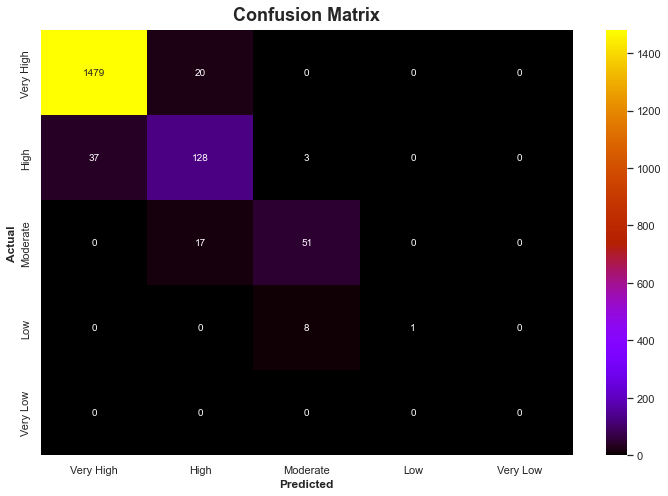

In [8]:
ypred = cat.predict(xtest)
plt.figure(figsize = (10, 7))
class_labels = ['Very High', 'High', 'Moderate', 'Low', 'Very Low']
sns.heatmap(confusion_matrix(ytest, ypred, labels = [0, 1, 2, 3, 4]), annot = True, cmap = 'gnuplot', fmt = 'd', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
print(f"Accuracy: {accuracy_score(ytest, ypred):.2f}")
print("\n")
print(classification_report(ytest, ypred))

Accuracy: 0.95


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1499
           1       0.78      0.76      0.77       168
           2       0.82      0.75      0.78        68
           3       1.00      0.11      0.20         9

    accuracy                           0.95      1744
   macro avg       0.89      0.65      0.68      1744
weighted avg       0.95      0.95      0.95      1744

